# Solution Assignment 2 2019 (BEF)

In [38]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import pandas as pd

# 1. Preparation

## Preferences

The agent has $(\beta,\delta)$ preferences with CRRA utility ($\gamma$ is the relative risk aversion coefficient). We take the following values

In [39]:
beta = 0.8
delta = 0.95
gamma = 0.75

In [40]:
def u(c,gamma):
    if gamma==1.0:
        return np.log(c)
    else :
        return  c**(1.0-gamma)/(1.0-gamma)

## Ressources

The agent has income which grows and then drops at retirement. He starts making decisions at age 25 (t=0). He lives for 55 years (dies at 80) with retirement at 40 (age 65). He starts off with no wealth. He can make one choice during working years: save in a retirement account a fraction $s$ of his income. Upon retiring, he gets gets annuity income from how much he has accumulated. The employer matches his contributions with 50 cents on the dollar of contribution. He faces a one-time cost of starting contributions, $k$. Once he started, he always saves $s$. 

In [41]:
R = 1.0/delta
r = R-1.0
T = 55
ret = 40
base = 30e3
g = 0.01
rep = 0.4
income = [base*np.exp(g*t) for t in range(T)]
for t in range(T):
    if (t>=ret):
        income[t] = income[ret-1]*rep
w0 = 0.0
age = [25+t for t in range(T)]
nw = 500
wmin = 0.0
wmax = 5e5
gw = np.linspace(wmin,wmax,nw)
s = 0.06
mu = 0.5
k = 2500.0

## Solutions

In [42]:
def solve_edu(delta,gamma,k,s,mu):
    V = np.zeros((nw,ret))
    sopt = np.zeros((nw,ret))
    for i,w in enumerate(gw):
        ann = r/(1.0-R**(ret-T))*w
        V[i,ret-1] = np.sum([(delta**q) * u(income[ret+q-1] + ann,gamma) for q in range(T-ret)])
        if w==0:
            sopt[i,ret-1] = 0.0
        else :
            sopt[i,ret-1] = 1.0
    for t in reversed(range(ret-1)):
        Ev = interp1d(gw,V[:,t+1],fill_value='extrapolate')
        for i,w in enumerate(gw):
            ww = R*(w+s*(1.0+mu)*income[t])
            if (w==0.0):
                v0 = u(income[t],gamma) + delta * V[0,t+1]
                v1 = u(income[t] - s*income[t] - k,gamma) + delta*Ev(ww)
                if (v1>v0):
                    sopt[i,t] = 1.0
                    V[i,t] = v1
                else :
                    V[i,t] = v0
            else :
                V[i,t] = u(income[t] - s*income[t],gamma) + delta*Ev(ww)
                sopt[i,t] = 1.0
    ageopt = 0
    for t in range(ret-1):
        if (sopt[0,t]==1.0):
            ageopt = t
            break
    return ageopt,V

In [43]:
def solve_pbu(beta,delta,gamma,k,s,mu,V):
    spb = np.zeros((nw,ret))
    for t in reversed(range(ret-1)):
        Ev = interp1d(gw,V[:,t+1],fill_value='extrapolate')
        for i,w in enumerate(gw):
            ww = R*(w+s*(1.0+mu)*income[t])
            if (w==0.0):
                v0 = u(income[t],gamma) + beta*delta * V[0,t+1]
                v1 = u(income[t] - s*income[t] - k,gamma) + beta*delta*Ev(ww)
                if (v1>v0):
                    spb[i,t] = 1.0
            else :
                spb[i,t] = 1.0
    ageopt = 0
    for t in range(ret-1):
        if (spb[0,t]==1.0):
            ageopt = t
            break
    return ageopt

In [44]:
def welfare(ageopt,k,s,mu):
    eu = 0.0
    wlth = 0.0
    for t in range(T):
        if t<ret:
            if t<ageopt:
                cons = income[t]
            elif t==ageopt:
                cons = income[t] - s*income[t] - k
                wlth = R*(wlth+s*(1.0+mu)*income[t])
            else :
                cons = income[t] - s*income[t] 
                wlth = R*(wlth+s*(1.0+mu)*income[t])
        else :
            ann = r/(1.0-R**(ret-T))*wlth
            cons = income[t] + ann
        util = u(cons,gamma)
        eu += (delta**t)*util
    return eu

In [45]:
def getwlth(ageopt,s,mu):
    wlth = np.zeros(ret)
    for t in range(ret):
        if t<ageopt:
            wlth[t]
        if t>=ageopt:
            wlth[t] = R*(wlth[t-1]+s*(1.0+mu)*income[t])
    return wlth
            

In [46]:
def incfunc(ret,rep):
    income = [base*np.exp(g*t) for t in range(T)]
    for t in range(T):
        if (t>=ret):
            income[t] = income[ret-1]*rep
    return income

In [47]:
def npv(inc,r):
    return np.sum([i*(1.0+r)**(-t) for t,i in enumerate(inc)])

# 2. Preliminaries

### 2.1 Plot income

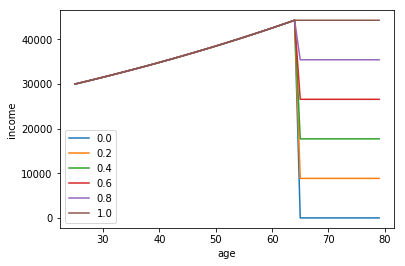

In [48]:
reps = np.linspace(0.0,1.0,6)
plt.figure()
for rr in reps: 
    plt.plot(age,incfunc(ret,rr),label=str(np.round(rr,1)))
plt.xlabel('age')
plt.ylabel('income')
plt.legend()
plt.show()

## 2.2 NPV

In [49]:
npv(incfunc(ret,rep),1.0/delta-1.0)

623882.5294051864

## 2.3 Motivation for $k$

switching cost. Could be monetary, time or effort. 

## 2.4 Annuity

Use the result for geometric series. 

## 3. Understanding the EDU model

### 3.1 Path of wealth

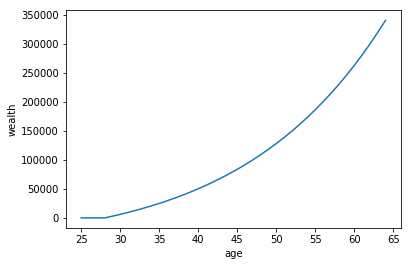

In [50]:
ageopt,V = solve_edu(delta,gamma,k,s,mu)
wlth = getwlth(ageopt,s,mu)
plt.figure()
plt.plot(age[:ret],wlth)
plt.xlabel('age')
plt.ylabel('wealth')
plt.show()

In [51]:
ageopt, wlth[-1:]

(4, array([340721.16174343]))

### 3.2 Sensitivity to $\delta$, $\gamma$

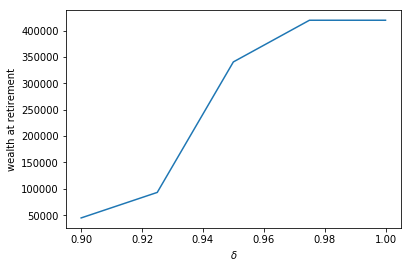

In [52]:
deltas = np.linspace(0.9,1.0,5)
wret = []
for d in deltas: 
    ageopt,V = solve_edu(d,gamma,k,s,mu)
    wlth = getwlth(ageopt,s,mu)
    wret.append(wlth[-1:])
plt.figure()
plt.plot(deltas,wret)
plt.xlabel('$\delta$')
plt.ylabel('wealth at retirement')
plt.show()

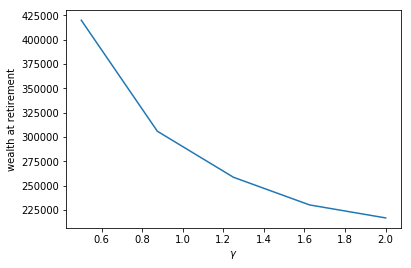

In [53]:
gammas = np.linspace(0.5,2.0,5)
wret = []
for gg in gammas: 
    ageopt,V = solve_edu(delta,gg,k,s,mu)
    wlth = getwlth(ageopt,s,mu)
    wret.append(wlth[-1:])
plt.figure()
plt.plot(gammas,wret)
plt.xlabel('$\gamma$')
plt.ylabel('wealth at retirement')
plt.show()

### 3.3 variation with $rep$

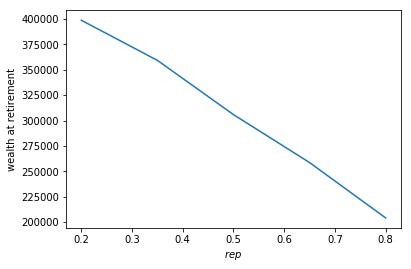

In [54]:
reps = np.linspace(0.2,0.8,5)
wret = []
pensions = []
anns = []
for rr in reps: 
    income = incfunc(ret,rr)
    pensions.append(income[ret+1])
    ageopt,V = solve_edu(delta,gamma,k,s,mu)
    wlth = getwlth(ageopt,s,mu)
    ann = r/(1.0-R**(ret-T))*wlth[-1:]
    anns.append(r/(1.0-R**(ret-T))*ann[0])
    wret.append(wlth[-1:])
plt.figure()
plt.plot(reps,wret)
plt.xlabel('$rep$')
plt.ylabel('wealth at retirement')
plt.show()

In [55]:
tab = pd.DataFrame(data={'rep': reps, 'pensions': pensions, 'annuity': anns})
tab.set_index('rep')

,annuity,pensions
rep,,
0.20,3834.920890,8861.884763
0.35,3455.031339,15508.298336
0.50,2940.905737,22154.711908
0.65,2486.682988,28801.125481
0.80,1962.290508,35447.539053


He is off-seting the increase in the pension. Of course, here, nobody pays for the increase in pension. So he does not need to perfectly offset. 

## 4. Present-Bias

### 4.1 Compare EDU and PB

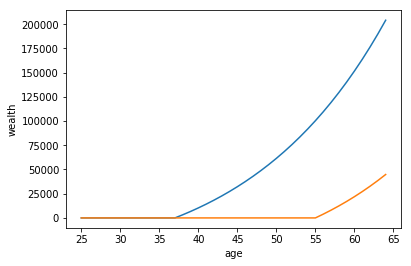

In [56]:
ageopt,V = solve_edu(delta,gamma,k,s,mu)
wlth = getwlth(ageopt,s,mu)
ageopt_pbu = solve_pbu(beta,delta,gamma,k,s,mu,V)
wlth_pbu = getwlth(ageopt_pbu,s,mu)
plt.figure()
plt.plot(age[:ret],wlth,label='EDU')
plt.plot(age[:ret],wlth_pbu,label='EDU')
plt.xlabel('age')
plt.ylabel('wealth')
plt.show()

### 4.2 Welfare

In [59]:
edu = welfare(ageopt,k,s,mu)
pbu = welfare(ageopt_pbu,k,s,mu)
print(edu,pbu)

1025.967727835699 1024.8693390069566


### 4.3 Wealth when $\beta$ varies

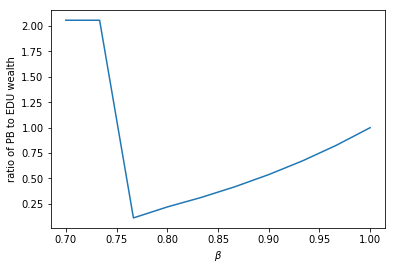

In [67]:
betas = np.linspace(0.7,1.0,10)
ageopt,V = solve_edu(delta,gamma,k,s,mu)
wlth = getwlth(ageopt,s,mu)
ratio = []
for b in betas: 
    ageopt_pbu = solve_pbu(b,delta,gamma,k,s,mu,V)  
    wlth_pbu = getwlth(ageopt_pbu,s,mu)
    ratio.append(wlth_pbu[-1:]/wlth[-1:])
plt.figure()
plt.plot(betas,ratio)
plt.xlabel('$\\beta$')
plt.ylabel('ratio of PB to EDU wealth')
plt.show()